<div id="toc-static"></div>

The basic use of the *pyphs.PortHamiltonianObject* is illustrated here with the modeling and time-domain simulation of the standard resistor-coil-capacitor (RLC) circuit.
<!-- TEASER_END -->
Details on the PHS modeling of the RLC circuit can be found in the academic reference [[1, §2.2]](http://www.mdpi.com/2076-3417/6/10/273/pdf).

# System declaration
## Governing equations
Following the reference [[1, §2.2]](http://www.mdpi.com/2076-3417/6/10/273/pdf), the RLC circuit is described as follows:
* $x_L$ is the coil flux so that $v_L = \frac{\mathrm d x_L}{\mathrm d  t}$ is the coil voltage, 
* $x_C$ is the electric charge associated with the capacitor so that $i_C = \frac{\mathrm d x_C}{\mathrm d  t}$ is the capacitor current, 
* $w_R= i_R$ is the resistor current, 
* $y=i_{\mathrm{out}}$ is the output current, and 
* $u=v_{\mathrm{out}}$ is the input voltage.

The constitutive laws are:
* the quadratic storage function $H(x_L, x_C)=\frac{x_L^2}{2L}+\frac{x_C^2}{2C},$ so that the coil current is $i_L=\frac{\partial H}{\partial x_L}=\frac{x_L}{L}$ and the capacitor voltage is $v_C=\frac{\partial H}{\partial x_C}=\frac{x_C}{C}$,
* the linear dissipation function $z_R(w_R)= R \,w_R = v_R$ with $v_R$ the resistor voltage. 

The Kirchhoff's laws for a serial connection read: 
* Kirchhoff's current law: $ v_L=-v_C-v_R-v_{\mathrm{out}}$,
* Kirchhoff's voltage law: $i_L = i_C = i_R = i_{\mathrm{out}}$.

This can be expressed in the *Port-Hamiltonian Systems* (PHS) formalism as:

$$\left(\begin{array}{c}\frac{\mathrm d x_L}{\mathrm d  t} \\ \frac{\mathrm d x_C}{\mathrm d  t}\\ \hline w_R\\ \hline y \end{array}\right)=\left(\begin{array}{cc|c|c}
0 & -1 & -1 & -1\\ 
1 & 0 & 0 & 0 \\ \hline
1 & 0 & 0 & 0 \\  \hline
1 & 0 & 0 & 0
\end{array}\right)\cdot \left(\begin{array}{c}\frac{\partial H}{\partial x_C}\\ \frac{\partial H}{\partial x_L}\\ \hline z_R\\ \hline u \end{array}\right) $$

The physical parameters are 
* $C=2\times 10^{-9}$F, 
* $L=50\times 10^{-3}$H, 
* $R = 10^3\Omega$.

## PyPHS declaration
### Import pyphs
As any python module, we need to timport `pyphs` before using it:

In [1]:
import pyphs

### Instantiation of a port-Hamiltonian system
The entry point to the pyphs package is the `pyphs.PortHamiltonianObject`. Help can be obtained with
```python
help(pyphs.PortHamiltonianObject)
```

It is recommanded to pass the label argument at the instantation:

In [2]:
phs = pyphs.PortHamiltonianObject(label='RLC', path='MyFolder')

Now, `phs` is an instance of `pyphs.PortHamiltonianObject`:

In [3]:
phs

<pyphs.pyphs.PortHamiltonianObject instance at 0x104c574d0>

### Adding the components
#### Defining symbols
The `pyphs` package is based on the `sympy` package to provide the symbolic manipulation of PHS structures. To declare symbols, we use the `phs.symbols` method. As an example, we declare below the symbols associated with the coil: 
* the state $x_L$ (magnetic flux of the coil), and 
* the parameter $L$ (coil inductance).

In [4]:
xL, L = phs.symbols(['xL', 'L'])

#### Defining expressions
Now, the variables `xL` and `L` are instances of the `sympy.Symbol` object, with the assumption that quantities are real-valued only. Then, expressions can be defined with the standard `sympy` syntax. As an example, we define below the storage function associated with the coil $H_L(x_L)=\frac{x_L^2}{2L}$:

In [5]:
HL = xL**2/(2*L)

#### the `phs.add_storages` method
To include a storage component to a `PortHamiltonianObject`, we make use of the `phs.add_storages` method:

In [6]:
help(phs.add_storages)

Help on method add_storages in module pyphs.pyphs:

add_storages(self, x, H) method of pyphs.pyphs.PortHamiltonianObject instance
    Add a storage component with state x and energy H.
    * State x is append to the current list of states symbols,
    * Expression H is added to the current expression of Hamiltonian.
    
    Parameters
    ----------
    
    x : str, symbol, or list of
    H : sympy.Expr



As an example, the coil is added to the `phs` object as follows:

In [7]:
phs.add_storages(xL, HL)

For the capacitor:
* the state is $x_C$ (electric charge),
* the parameter is $C$ (electric capacitance), and 
* the storage function is $H_C(x_C)=\frac{x_C^2}{2C}$.

This component is added to the `phs` object as follows: 

In [8]:
xC, C = phs.symbols(['xC', 'C'])
HC = xC**2/(2*C)
phs.add_storages(xC, HC)

Now, the state of the `phs` object includes both `xL` and `xC`:

In [9]:
phs.symbs.x

[xL, xC]

and the storage function is given by the sum of `HL` and `HC`:

In [10]:
phs.exprs.H

xL**2/(2*L) + xC**2/(2*C)

Notice the same results can be obtained with a single call to `add_storages` by 
1. defining a list of states:
```python
x = [xL, xC]
```
2. defining a total storage function:
```python
H = HL + HC
```
3. calling:
```python
phs.add_storages(x, H)
```

#### the `phs.add_dissipations` method
To include a dissipative component to a `PortHamiltonianObject`, we make use of the `phs.add_dissipations` method:

In [11]:
help(phs.add_dissipations)

Help on method add_dissipations in module pyphs.pyphs:

add_dissipations(self, w, z) method of pyphs.pyphs.PortHamiltonianObject instance
    Add a dissipative component with dissipation variable w and dissipation function z.
    
    Parameters
    ----------
    
    w : str, symbol, or list of
    z : sympy.Expr or list of



Recall the resistor is decribed by:
* the dissipative variable $w_R$ (resistor current),
* the parameter $R$ (electric resistance), and 
* the dissipation function $z_R(w_R)=R\,w_R$.

This component is added to the `phs` object as follows: 

In [12]:
wR, R = phs.symbols(['wR', 'R'])    # define sympy symbols
zR = R*wR                           # define sympy expression
phs.add_dissipations(wR, zR)        # add dissipation to the `phs` object

Now, the dissipative variable of the `rlc` object includes `wR` only:

In [13]:
phs.symbs.w

[wR]

and the dissipation function is given by `zR` only:

In [14]:
phs.exprs.z

[R*wR]

#### the `phs.add_ports` method
To include an external port to a `PortHamiltonianObject`, we make use of the `phs.add_ports` method:

In [15]:
help(phs.add_ports)

Help on method add_ports in module pyphs.pyphs:

add_ports(self, u, y) method of pyphs.pyphs.PortHamiltonianObject instance
    Add one or several ports with input u and output y.
    
    Parameters
    ----------
    
    u : str, symbol, or list of
    y : str, symbol, or list of



Below, we define the external port with input $u=v_{\mathrm{out}}$ and output $y=i_{\mathrm{out}}$ (notice the symbols do not reflect the actual physical meaning of $u$ and $y$):

In [16]:
u, y = phs.symbols(['vout', 'iout']) # define sympy symbols
phs.add_ports(u, y)                  # add the port to the `phs` object

### Defining the interconnection structure
The interconnection structure of a PHS is defined by the matrix $\mathbf M$ structured as $$\mathbf M = \mathbf J- \mathbf R,$$ where 
* the skew-symmetric matrix $\mathbf J = \frac{1}{2}\left(\mathbf M- \mathbf M^\intercal\right) $ encodes the *conservative interconnection*, and 
* the symmetric positive definite matrix $\mathbf R = \frac{-1}{2}\left(\mathbf M + \mathbf M^\intercal\right)$ encodes the *dissipative interconnection*.

These matrices are decomposed in blocks as follows:
$$\mathbf M = \left( 
\begin{array}{lll}
\mathbf M_{\mathrm{xx}} & \mathbf M_{\mathrm{xw}} & \mathbf M_{\mathrm{xy}} \\
\mathbf M_{\mathrm{wx}} & \mathbf M_{\mathrm{ww}} & \mathbf M_{\mathrm{wy}} \\
\mathbf M_{\mathrm{yx}} & \mathbf M_{\mathrm{ww}} & \mathbf M_{\mathrm{yy}} \\
\end{array}\right), 
$$
$$
\mathbf J = \left( 
\begin{array}{lll}
\mathbf J_{\mathrm{xx}} & \mathbf J_{\mathrm{xw}} & \mathbf J_{\mathrm{xy}} \\
\mathbf J_{\mathrm{wx}} & \mathbf J_{\mathrm{ww}} & \mathbf J_{\mathrm{wy}} \\
\mathbf J_{\mathrm{yx}} & \mathbf J_{\mathrm{ww}} & \mathbf J_{\mathrm{yy}} \\
\end{array}\right), \quad\mathbf R = \left( 
\begin{array}{lll}
\mathbf R_{\mathrm{xx}} & \mathbf R_{\mathrm{xw}} & \mathbf R_{\mathrm{xy}} \\
\mathbf R_{\mathrm{wx}} & \mathbf R_{\mathrm{ww}} & \mathbf R_{\mathrm{wy}} \\
\mathbf R_{\mathrm{yx}} & \mathbf R_{\mathrm{ww}} & \mathbf R_{\mathrm{yy}} \\
\end{array}\right).$$

For the above description of the RLC circuit, the matrices are $$\mathbf M = \mathbf J = \left(\begin{array}{cc|c|c}
0 & -1 & -1 & -1\\ 
1 & 0 & 0 & 0 \\ \hline
1 & 0 & 0 & 0 \\  \hline
1 & 0 & 0 & 0
\end{array}\right),$$ 
that is, $\mathbf R=0$. Each block of the matrix $\mathbf J$ can be defined as a `numpy.array` as follows:

In [17]:
import numpy

Jxx = numpy.array([[0, -1],
                   [1, 0]])
phs.struc.set_Jxx(Jxx)

Jxw = numpy.array([[-1],
                   [0]])
phs.struc.set_Jxw(Jxw)

Jxy = numpy.array([[-1],
                   [0]])
phs.struc.set_Jxy(Jxy)

Then, the structure matrices are accessed as follows:

In [18]:
print('M=')
phs.struc.M

M=


Matrix([
[0, -1, -1, -1],
[1,  0,  0,  0],
[1,  0,  0,  0],
[1,  0,  0,  0]])

In [19]:
print('J=')
phs.struc.J()

J=


Matrix([
[  0, -1.0, -1.0, -1.0],
[1.0,    0,    0,    0],
[1.0,    0,    0,    0],
[1.0,    0,    0,    0]])

In [20]:
print('Jxx=')
phs.struc.Jxx()

Jxx=


Matrix([
[  0, -1.0],
[1.0,    0]])

In [21]:
print('Jxw + Jwx.T =')
phs.struc.Jxw() + phs.struc.Jwx().T

Jxw + Jwx.T =


Matrix([
[0],
[0]])

In [22]:
print('R=')
phs.struc.R()

R=


Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

### Setting parameters values
The correspondence between the parameters symbols (here `L`, `C` and `R`) and their actual value is stored in the python dictionary `phs.symbs.subs`, with parameters symbols as the dictionary's keys and numerical values as the dictionary's values. Here, the physical parameters are 
* $L=50\times 10^{-3}$H, 
* $C=2\times 10^{-9}$F, 
* $R = 10^3\Omega$:

In [23]:
L_value = 50e-3
C_value = 2e-9
R_value = 1e3

subs = {L: L_value,
        C: C_value,
        R: R_value}

phs.symbs.subs.update(subs)

## Generate the $\LaTeX$ description
A `.tex` file containing a description of the system can now be generated with the `phs.texwrite` command as follows:

In [24]:
phs.texwrite()

The `.tex` file is generated in the folder returned by
```python
phs.paths['tex']
```
which, on Mac OSX, returns something like:
```
/Users/bla/bla/bla/RLC/tex
```
In that folder, a [RLC.tex](/pyphs_outputs/RLC/RLC.tex) file is now accessible. Compiling this file yields the following [RLC.pdf](/pyphs_outputs/RLC/RLC.pdf)

# System simulation
The methods for the simulations are parts of the `phs.simu` module. In the sequel, simulations perform at the following sampling frequency:

In [25]:
fs = 48e3  # Samplerate (Hz)

## Input sequence: generators
The input to the simulations methods in the `phs.simu` module are python `generators`. In short, the elements of these structures are not loaded into memory before being accessed. In turn, the data can be accessed only once.

The `phs.signalgenerator` function returns generators for a variety of signals. As an example, we choose to define the input voltage signal as follows:
$$u(t) = v_{\mathrm{out}}(t) = A(t)\,\sin(2\pi\,f_0/,t) $$
with linearly increasing amplitude $A$. The associated call to `phs.signalgenerator` reads

In [26]:
A = 100.                           # signal amplitude
f0 = 100.                          # signal fondamental frequency
nsin = int(5*fs/f0)                # number of time-steps

# signal generator
vout = phs.signalgenerator(which="sin",
                          n=nsin,
                          ramp_on=True,
                          A=A,
                          f0=f0,
                          fs=fs)

See `help(phs.signalgenerator)` for details. Notice `vout` is a `function` that yields a python `generator`:

In [27]:
print(type(vout))
print(type(vout()))

<type 'function'>
<type 'generator'>


Now, we need to define the **input sequence generator**, which should yield a list of *np* floats for each time-step, with *np* the number of inputs. Here, *np*=1 which corresponds to the following input sequence generator:

In [28]:
def genu():
    """
    Input sequence generator
    """
    for el in vout():
        yield [el, ]  # each call to the generator...
                      # ... yields a list with a single element.

## Initialization
The `phs.simu` module must be initilized before running the simulations. This is done with the `phs.simu.init` command. First, we define a **minimal** dictionary of user-specified pre-processing, processing, and post-processing options:

In [29]:
opts = {'fs': fs}

Secondly, the `phs.simu` module is initilized with

In [30]:
phs.simu.init(sequ=genu(), nt=nsin, opts=opts)

*** Resolution of linear subsystem succeed ***


## Processing
The simulation can now proceed:

In [31]:
phs.simu.process()


*** Simulation ***



## Plots

In [32]:
# Shows the plots in the notebook
%matplotlib inline

The `pyphs` package includes several ploting possibilities to analyse the simulation results. As an example, the power balance can be shown with

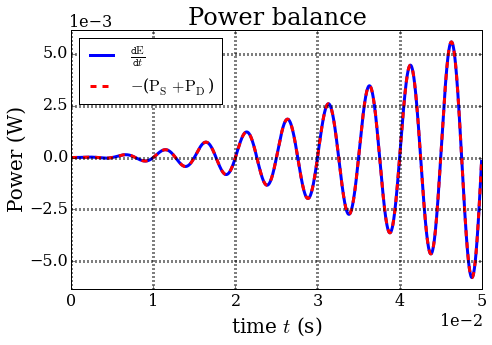

In [33]:
phs.plot_powerbal()